In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

!pip install xgboost
%matplotlib inline
import sklearn as sklearn
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
#from sklearn.neural_network import MLPRegressor

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')
test=pd.read_csv('../../1. Task and Data/test.csv',sep='|')

y_train= train['fraud']
x_train= train.drop('fraud',axis=1)

x_train, x_holdout, y_train, y_holdout = train_test_split(x_train, y_train, test_size=0.2, random_state=324)

features = x_train.columns
target = 'fraud'

model_factory = [
 RandomForestClassifier(),
 XGBClassifier(nthread=1),
 #MLPRegressor(),
 LinearDiscriminantAnalysis(),
 SVC(),
 #Ridge(),
 #BayesianRidge(),
 ExtraTreesClassifier(),
 #ElasticNet(),
 KNeighborsClassifier(),
 GradientBoostingClassifier()
]

#sorted(sklearn.metrics.SCORERS.keys())

for model in model_factory:
    model.seed = 42
    num_folds = 10

    scores = cross_val_score(model, x_train, y_train, cv=num_folds, scoring='balanced_accuracy')
    score_description = " %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-5 BAC: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestClassifier    CV-5 BAC:  0.76 (+/- 0.24)
XGBClassifier             CV-5 BAC:  0.83 (+/- 0.15)
LinearDiscriminantAnalysis CV-5 BAC:  0.51 (+/- 0.05)
SVC                       CV-5 BAC:  0.50 (+/- 0.00)
ExtraTreesClassifier      CV-5 BAC:  0.63 (+/- 0.16)
KNeighborsClassifier      CV-5 BAC:  0.50 (+/- 0.00)
GradientBoostingClassifier CV-5 BAC:  0.84 (+/- 0.16)


# Pseudo Labeling

In [17]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

In [19]:
model = PseudoLabeler(
    XGBClassifier(nthread=1),
    test,
    features,
    target,
    sample_rate = 0.3
)

model.fit(x_train, y_train)
pred = model.predict(x_holdout)
cross_val_score(model, x_train, y_train, cv=num_folds, scoring='balanced_accuracy', n_jobs=8)

sub = pd.DataFrame(data = pred, columns=['fraud'])
sub.to_csv('pseudo-labelling.csv', index='False')

# Comparison XGB vs. SSL Pseudo XGB

In [22]:
model_factory = [
 XGBClassifier(nthread=1),
 PseudoLabeler(
 XGBClassifier(nthread=1),
 test,
 features,
 target,
 sample_rate=0.3
 ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 10

    scores = cross_val_score(model, x_train, y_train, cv=num_folds, scoring='balanced_accuracy', n_jobs=8)
    score_description = " %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-{num_folds} BAC: {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

XGBClassifier             CV-10 BAC:  0.8308 (+/- 0.1509)
PseudoLabeler             CV-10 BAC:  0.8247 (+/- 0.1425)


# Sample Rate Tuning

In [23]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestClassifier(n_jobs=1),
    XGBClassifier(nthread=1),
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 10

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
        
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, x_train, y_train, cv=num_folds, scoring='balanced_accuracy', n_jobs=8)
        results[model_name].append(scores.mean())

RandomForestClassifier
XGBClassifier


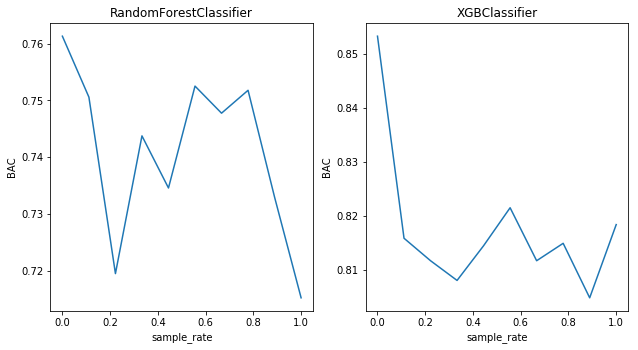

In [25]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('BAC')
    

plt.show()